In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.colors as colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.collections import LineCollection
from matplotlib import cm
from datetime import datetime
from scipy.special import gamma
from scipy.interpolate import interp1d

In [2]:
# Helper function to - you guessed it - make sexy axes for generic values
def sexy_axes(ax,fs):
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left') 
    ax.tick_params('both',labelsize=fs,rotation=45)

In [3]:
# Helper function to make sexy axes for pressure levels
def sexy_axes2(ax, fs, ylab):
    ax.set_ylim([50,800])
    ax.set_yscale('log')
    ax.set_yticks([800,500,300,100])
    ax.set_yticklabels(['800','500','300','100'])
    if ylab == True:
        ax.set_ylabel('Pressure [hPa]',fontsize=fs)
    ax.invert_yaxis()
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left') 
    ax.tick_params('both',labelsize=fs,rotation=45)

# Figure 1: Motivational heating profiles, domain topography, and vertical grid spacing

### Panel b: Read in topography map

In [9]:
# Domain topography map
file = '/work/bb1018/b380459/TROPIC/extpar/extpar_icon-grid_tropic_55e170e5s40n_R2500m_bitmap.nc'
dset = xr.open_dataset(str(file))
x, y = dset['lon'].values, dset['lat'].values  # shape = (9648304,)

# Flight 7 track
#basedir = '/work/bb1018/b380873/tropic_vis/'
#scfi = basedir + 'obs/stratoclim2017.geophysika.0808_1.master.ci_eval.nc'
#sc_data = xr.open_dataset(scfi)
#lat_sc = sc_data['BEST:LAT'].values
#lon_sc = sc_data['BEST:LON'].values
#t_sc = sc_data['time'].values
#i_sc = np.argwhere((~np.isnan(lat_sc)) & (~np.isnan(lon_sc)) & (lat_sc > 0) & (lon_sc > 0))

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Truncate a coloramp by specifying the start and endpoint."""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n}.{a:.2f},{b:.2f})'.format(n=cmap.name,a=minval,b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return(new_cmap)

### Panel c: Read in the vertical levels

In [27]:
# Load the default vertical grid with 75 levels.
basedir = '/work/bb1018/b380873/'
vgrid = xr.open_dataset(basedir + 'vgrid_icon-grid_tropic_55e115e5s40n.nc')
vct_a = vgrid['vct_a'].values
diff1 = np.zeros((vct_a.shape[0]-1,2))
for i in np.arange(vct_a.shape[0]-1):
    d = vct_a[i] - vct_a[i+1]
    diff1[i,0] = d[0]
    d = (vct_a[i] + vct_a[i+1])/2
    diff1[i,1] = d[0]

In [28]:
# Load the higher-resolution vertical grid with 120 levels.
vgrid = xr.open_dataset(basedir + 'vgrid_max_lay_thckn_200.nc')
vct_a = vgrid['vct_a'].values
diff2 = np.zeros((vct_a.shape[0]-1,2))
for i in np.arange(vct_a.shape[0]-1):
    d = vct_a[i] - vct_a[i+1]
    diff2[i,0] = d[0]
    d = (vct_a[i] + vct_a[i+1])/2
    diff2[i,1] = d[0]

### Panel a: Read in Aiko's MPI and LMD sims, Nicole's ICON sims, and George's CloudSat values

In [8]:
# These values were calculated in ./rad/amip_cloud_radheating_AMA.ipynb
bd = './output/'
mpi_dtlw_trop = np.load(bd + 'mpi_dtlw_trop',allow_pickle=True)
mpi_dtlwcs_trop = np.load (bd + 'mpi_dtlwcs_trop',allow_pickle=True)
mpi_dtsw_trop = np.load(bd + 'mpi_dtsw_trop',allow_pickle=True)
mpi_dtswcs_trop = np.load(bd + 'mpi_dtswcs_trop',allow_pickle=True)
mpi_dtlev = np.load(bd + 'mpi_dtlev',allow_pickle=True)

mpi_dtlw_AMA = np.load(bd + 'mpi_dtlw_AMA',allow_pickle=True)
mpi_dtlwcs_AMA = np.load(bd + 'mpi_dtlwcs_AMA',allow_pickle=True)
mpi_dtsw_AMA = np.load(bd + 'mpi_dtsw_AMA',allow_pickle=True)
mpi_dtswcs_AMA = np.load(bd + 'mpi_dtswcs_AMA',allow_pickle=True)
mpi_dtlev_AMA = np.load(bd + 'mpi_AMA',allow_pickle=True)

lmd_dtlw_trop = np.load(bd + 'lmd_dtlw_trop',allow_pickle=True)
lmd_dtlwcs_trop = np.load(bd + 'lmd_dtlwcs_trop',allow_pickle=True)
lmd_dtsw_trop = np.load(bd + 'lmd_dtsw_trop',allow_pickle=True)
lmd_dtswcs_trop = np.load(bd + 'lmd_dtswcs_trop',allow_pickle=True)
lmd_dtlev = np.load(bd + 'lmd_dtlev.npy')

lmd_dtlw_AMA = np.load(bd + 'lmd_dtlw_AMA',allow_pickle=True)
lmd_dtlwcs_AMA = np.load(bd + 'lmd_dtlwcs_AMA',allow_pickle=True)
lmd_dtsw_AMA = np.load(bd + 'lmd_dtsw_AMA',allow_pickle=True)
lmd_dtswcs_AMA = np.load(bd + 'lmd_dtswcs_AMA',allow_pickle=True)
lmd_dtlev_AMA = np.load(bd + 'lmd_dtlev_AMA.npy')

ico_dtlw_trop = np.load(bd + 'ico_dtlw_trop',allow_pickle=True)
ico_dtlwcs_trop = np.load(bd + 'ico_dtlwcs_trop',allow_pickle=True)
ico_dtsw_trop = np.load(bd + 'ico_dtsw_trop',allow_pickle=True)
ico_dtswcs_trop = np.load(bd + 'ico_dtswcs_trop',allow_pickle=True)
ico_dtlev = np.load(bd + 'ico_dtlev',allow_pickle=True)

ico_dtlw_AMA = np.load(bd + 'ico_dtlw_AMA',allow_pickle=True)
ico_dtlwcs_AMA = np.load(bd + 'ico_dtlwcs_AMA',allow_pickle=True)
ico_dtsw_AMA = np.load(bd + 'ico_dtsw_AMA',allow_pickle=True)
ico_dtswcs_AMA = np.load(bd + 'ico_dtswcs_AMA',allow_pickle=True)

cs_dtlwcl_trop = np.load(bd + 'cs_dtlwcl_trop',allow_pickle=True)
cs_dtswcl_trop = np.load(bd + 'cs_dtswcl_trop',allow_pickle=True)
cs_dtlev = np.load(bd + 'cs_dtlev',allow_pickle=True)

cs_dtlwcl_AMA = np.load(bd + 'cs_dtlwcl_AMA',allow_pickle=True)
cs_dtswcl_AMA = np.load(bd + 'cs_dtswcl_AMA',allow_pickle=True)

### Plot the three panels

<xarray.DataArray 'topography_c' ()>
array(8444.875)


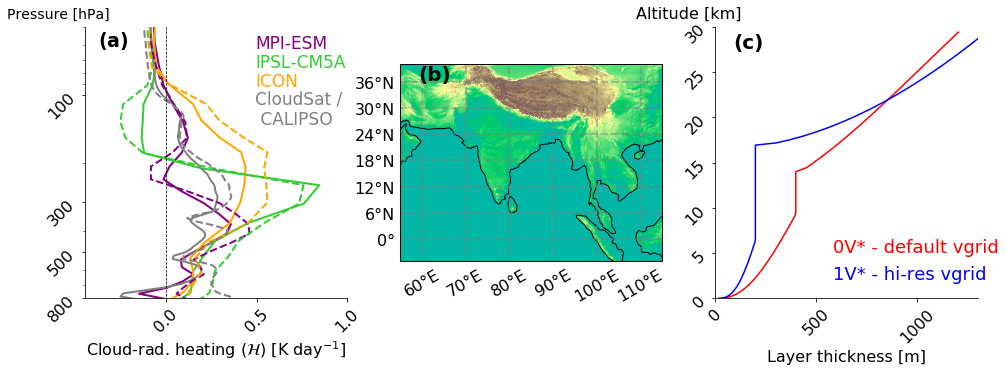

In [30]:
fs = 16
fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3)
ax0 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())

cmap = truncate_colormap(plt.get_cmap('terrain'), 0.2, 1.)
ax0.tricontourf(x, y, dset['topography_c'], cmap=cmap, levels=np.arange(-100,8500,10))
print(dset['topography_c'].max())
ax0.coastlines()
ax0.set_extent([55, 115, -5, 40],crs=ccrs.PlateCarree())
ax0.text(0.07,0.92,'(b)',weight='bold',fontsize=fs+4,transform=ax0.transAxes)

gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fs, 'rotation': 30}
gl.ylabel_style = {'size': fs}

# Excluding the flight track since it is not relevant for this study.
## Pulling from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
## Create a set of line segments so that we can color them individually
#points = np.array([lon_sc[i_sc[:,0]],lat_sc[i_sc[:,0]]]).T.reshape(-1,1,2)
#segments = np.concatenate([points[:-1],points[1:]],axis=1)

## Convert the times from np.datetime64 to float
#t_sc1 = t_sc[i_sc[:,0]]
#t_sc_f = t_sc1.astype("float")/1000000000.0
#t_sc_f = t_sc_f - np.nanmin(t_sc_f)
#norm = plt.Normalize(t_sc_f.min(),t_sc_f.max())
#lc = LineCollection(segments,cmap=cm.autumn,norm=norm)
#lc.set_array(t_sc_f)
#lc.set_linewidth(2)
#ax0.add_collection(lc)

ax1 = fig.add_subplot(gs[0,2])
ax1.plot(diff1[:,0],diff1[:,1]/1000,color='red')
ax1.plot(diff2[:,0],diff2[:,1]/1000,color='blue')
ax1.set_xlabel('Layer thickness [m]',fontsize=fs)
ax1.set_ylabel('Altitude [km]',fontsize=fs,rotation=0)
ax1.set_ylim([0,30])
ax1.set_xlim([0,1300])
ax1.text(0.45,0.17,'0V* - default vgrid',color='red',fontsize=fs+2,transform=ax1.transAxes)
ax1.text(0.45,0.07,'1V* - hi-res vgrid',color='blue',fontsize=fs+2,transform=ax1.transAxes)
ax1.text(0.07,0.92,'(c)',weight='bold',fontsize=fs+4,transform=ax1.transAxes)
sexy_axes(ax1,fs)
ax1.yaxis.set_label_coords(-0.1,1.02)

ax2 = fig.add_subplot(gs[0,0])
ax2.plot((mpi_dtlw_trop-mpi_dtlwcs_trop)+(mpi_dtsw_trop-mpi_dtswcs_trop),mpi_dtlev/100,
         color='purple',linewidth=2)
ax2.plot(((lmd_dtlw_trop-lmd_dtlwcs_trop)+(lmd_dtsw_trop-lmd_dtswcs_trop)),lmd_dtlev/100,
         color='limegreen',linewidth=2)
ax2.plot(((ico_dtlw_trop-ico_dtlwcs_trop)+(ico_dtsw_trop-ico_dtswcs_trop)),ico_dtlev/100,
         color='orange',linewidth=2)
ax2.plot(cs_dtlwcl_trop+cs_dtswcl_trop,cs_dtlev, color='gray',linewidth=2)

ax2.plot((mpi_dtlw_AMA-mpi_dtlwcs_AMA)+(mpi_dtsw_AMA-mpi_dtswcs_AMA),mpi_dtlev_AMA/100,'--',
         color='purple',linewidth=2)
ax2.plot(((lmd_dtlw_AMA-lmd_dtlwcs_AMA)+(lmd_dtsw_AMA-lmd_dtswcs_AMA)),lmd_dtlev_AMA/100,'--',
         color='limegreen',linewidth=2)
ax2.plot(((ico_dtlw_AMA-ico_dtlwcs_AMA)+(ico_dtsw_AMA-ico_dtswcs_AMA)),ico_dtlev/100,'--',
         color='orange',linewidth=2)
ax2.plot(cs_dtlwcl_AMA+cs_dtswcl_AMA,cs_dtlev, '--', color='gray',linewidth=2)

ax2.text(0.65,0.92,'MPI-ESM',fontsize=fs+1,color='purple',transform=plt.gca().transAxes)
ax2.text(0.65,0.85,'IPSL-CM5A',fontsize=fs+1,color='limegreen',transform=plt.gca().transAxes)
ax2.text(0.65,0.78,'ICON',fontsize=fs+1,color='orange',transform=plt.gca().transAxes)
ax2.text(0.65,0.64,'CloudSat / \n CALIPSO',fontsize=fs+1,color='gray',transform=plt.gca().transAxes)
ax2.plot([0,0],[50,1000], lw=0.75, linestyle='--', color='k')
ax2.text(0.05,0.93,r'$\bf{' + '(a)' + '}$',fontsize=fs+3,weight='bold',transform=ax2.transAxes)
ax2.set_xlabel(r'Cloud-rad. heating ($\mathcal{H}$) [K day$^{-1}$]',fontsize=fs)
ax2.set_xlim([-0.45,1])
sexy_axes2(ax2,fs,False)
ax2.set_ylabel('Pressure [hPa]', fontsize=fs-2, rotation=0)
ax2.yaxis.set_label_coords(-0.1,1.02)

fig.savefig('./output/3-topography-vgrid-spacing.png',bbox_inches='tight')

<xarray.DataArray 'topography_c' ()>
array(8444.875)


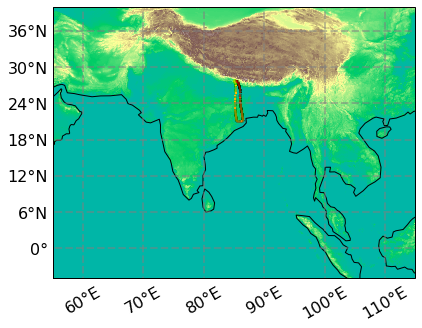

In [10]:
fs = 16
fig = plt.figure(figsize=(6.5,5))
gs = fig.add_gridspec(1,1)
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())

cmap = truncate_colormap(plt.get_cmap('terrain'), 0.2, 1.)
ax0.tricontourf(x, y, dset['topography_c'], cmap=cmap, levels=np.arange(-100,8500,10))
print(dset['topography_c'].max())
ax0.coastlines()
ax0.set_extent([55, 115, -5, 40],crs=ccrs.PlateCarree())

gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fs, 'rotation': 30}
gl.ylabel_style = {'size': fs}

# Pulling from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
# Create a set of line segments so that we can color them individually
points = np.array([lon_sc[i_sc[:,0]],lat_sc[i_sc[:,0]]]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]],axis=1)

# Convert the times from np.datetime64 to float
t_sc1 = t_sc[i_sc[:,0]]
t_sc_f = t_sc1.astype("float")/1000000000.0
t_sc_f = t_sc_f - np.nanmin(t_sc_f)
norm = plt.Normalize(t_sc_f.min(),t_sc_f.max())
lc = LineCollection(segments,cmap=cm.autumn,norm=norm)
lc.set_array(t_sc_f)
lc.set_linewidth(2)
ax0.add_collection(lc)

fig.savefig('./output/topography-flight-track-only.png',bbox_inches='tight')

## Figure 2: OLR maps and bin-smoothed histograms

In [4]:
# Read in the CERES data.
basedir = '/work/bb1018/b380873/tropic_vis/obs/CERES/'
olr_data = xr.open_dataset(basedir + 'CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Subset_20170801-20170831_full-domain.nc')
olr_ceres = olr_data.toa_lw_all_1h.sel(time=slice(datetime(2017,8,7,12,0,0),datetime(2017,8,8,12,0,0)))
olr_ceres = olr_ceres.mean(dim={'time'})
lons_ceres = olr_data.lon
lats_ceres = olr_data.lat

In [5]:
# Read in the ERA5 values.
basedir = '/work/bb1018/b380873/tropic_vis/obs/ERA5/'
olr_data = xr.open_dataset(basedir + 'ERA5_OLR-20170805-20170809.nc')
olr_era5 = olr_data.ttr.sel(time=slice(datetime(2017,8,7,12,0,0),datetime(2017,8,8,12,0,0)))
olr_era5 = -1.*olr_era5.mean(dim={'time'})/3600
lons_era5 = olr_data.longitude
lats_era5 = olr_data.latitude

In [6]:
# Read in the ICON 1-mom simulation.
basedir = '/work/bb1018/b380873/model_output/ICON/'
olr_data = xr.open_dataset(basedir + 'OLR_24h_tropic_run2_ll.nc')
olr_icon_1mom = -1.*olr_data.lwflxall.mean(dim={'time'}).sel(height=1)
lons_icon = olr_data.lon
lats_icon = olr_data.lat

# Read in the ICON 1-mom high vertical resolution simulation
olr_data = xr.open_dataset(basedir + 'OLR_12h_tropic_run5_no2mom_ll.nc')
olr_icon_1mom_vr = -1.*olr_data.lwflxall.mean(dim={'time'}).sel(height=1)

# Read in the ICON 2-mom simulation without higher vertical resolution.
olr_data = xr.open_dataset(basedir + 'OLR_12h_tropic_run5_novgrid_ll.nc')
olr_icon_2mom_novr = -1.*olr_data.lwflxall.mean(dim={'time'}).sel(height=1)

# Read in the ICON rad2mom simulation.
olr_data = xr.open_dataset(basedir + 'OLR_24h_tropic_run7_rad2mom_ll.nc')
olr_icon_rad2mom = -1.*olr_data.lwflxall.mean(dim={'time'}).sel(height=1)

# Read in the ICON PDA simulation.
olr_data = xr.open_dataset(basedir + 'OLR_24h_tropic_run8_pda_ll.nc')
olr_icon_pda = -1.*olr_data.lwflxall.mean(dim={'time'}).sel(height=1)

In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [8]:
# pulling this from the following stackoverflow
# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
def resize_colorbar(event):
    plt.draw()
    posn = joe.get_position()
    # left, bottom, width, height
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0 - 0.018,
                          0.025, posn.height + 0.03])
    cbar_ax.tick_params(labelsize=fs)
    #cbar_ax.set_ylabel(r'W m$^{-2}$', size=fs)

In [9]:
levs = np.linspace(80,375,15)
titre = [r'$\bf{' + '(a)' + '}$' + ' CERES',r'$\bf{' + '(b)' + '}$' + ' ERA5',
         r'$\bf{' + '(c)' + '}$' + ' 0V_1M_0A_0R',r'$\bf{' + '(d)' + '}$' + ' 1V_1M_0A_0R',
         r'$\bf{' + '(e)' + '}$' + ' 0V_2M_0A_0R',
         r'$\bf{' + '(f)' + '}$' + ' 0V_2M_0A_1R',r'$\bf{' + '(g)' + '}$' + ' 0V_2M_1A_0R']
farbe = ['gray', 'black', 'red', 'red', 'blue', 'goldenrod', 'green']
lons = [lons_ceres, lons_era5, lons_icon, lons_icon, lons_icon, lons_icon, lons_icon]
lats = [lats_ceres, lats_era5, lats_icon, lats_icon, lats_icon, lats_icon, lats_icon]
stil = ['-', '-', '-', '--', '-', '-', '-']
olr = [olr_ceres, olr_era5, olr_icon_1mom, olr_icon_1mom_vr, olr_icon_2mom_novr, olr_icon_rad2mom, olr_icon_pda]

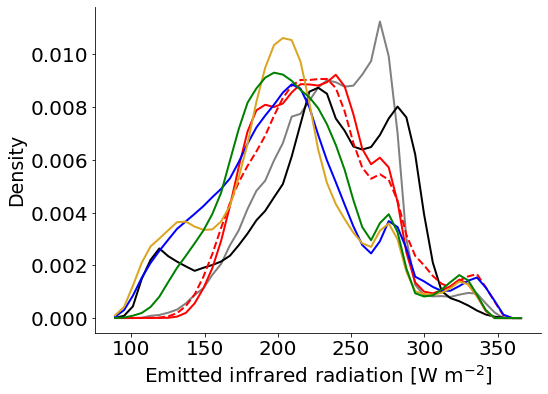

In [37]:
fs = 20
fig = plt.figure(figsize=(8,6))
levs = np.linspace(80,375,50)
h = np.zeros((7,len(levs)-1))
for i, o in enumerate(olr):
    h[i], b = np.histogram(o,bins=levs,density=True)
    yy = moving_average(h[i],3)
    plt.gca().plot(moving_average((levs[1:] + levs[:-1])/2,3), yy, linestyle=stil[i],
            linewidth=2, color=farbe[i])
    #plt.gca().plot([np.nanmean(o),np.nanmean(o)],[0,0.012], linestyle=stil[i], linewidth=4,
    #              color=farbe[i])

sexy_axes(plt.gca(),fs-2)
plt.gca().set_xlabel(r'Emitted infrared radiation [W m$^{-2}$]',fontsize=fs)
#plt.gca().yaxis.set_label_position("right")
#plt.gca().yaxis.tick_right()
#plt.gca().spines['left'].set_color('none')
#plt.gca().spines['right'].set_color('k')
#plt.xlim([190,250])
#plt.ylim([0,0.012])
plt.gca().tick_params('both',labelsize=fs,rotation=0)
plt.gca().set_ylabel('Density',fontsize=fs-1)
fig.savefig('./output/olr-histogram.pdf',bbox_inches='tight')

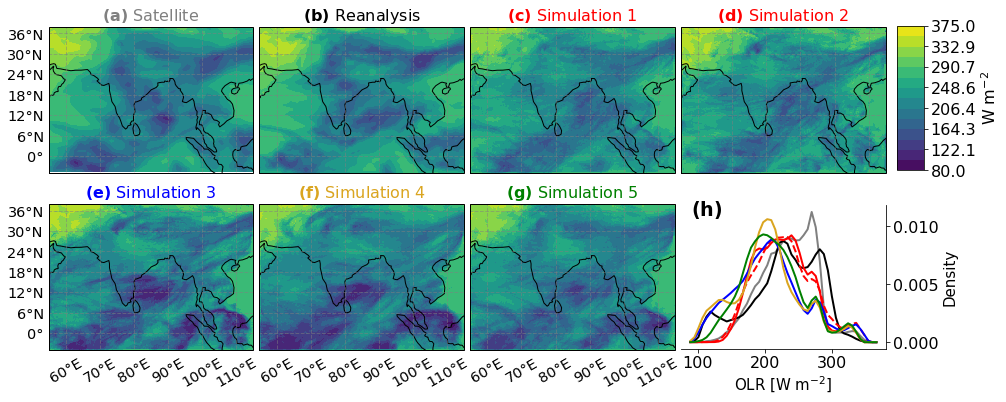

In [12]:
fs = 16
fig = plt.figure(figsize=(15,6.5))
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
gs = fig.add_gridspec(4,4)

c = 0
for j in np.arange(2):
    for i in np.arange(4):
        if j == 1 and i == 3:
            continue
        ax = fig.add_subplot(gs[j*2:j*2+2,i], projection=ccrs.PlateCarree())
        ax.set_title(titre[c],color=farbe[c],fontsize=fs)
        # Save the final axis on the upper row to add the colorbar
        if j == 0 and i == 3:
            joe = ax
            
        im = ax.contourf(lons[c],lats[c],olr[c],levels=levs,cmap=cm.viridis,\
                  transform=ccrs.PlateCarree())
        gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,
                linewidth=1,color='gray',alpha=0.5,linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        if i != 0:
            gl.ylabels_left = False
        if j == 0:
            gl.xlabels_bottom = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.rotate_labels=True
        gl.xlabel_style = {'size': fs-1.5,'rotation': 30}
        gl.ylabel_style = {'size': fs-1.5}

        ax.set_extent([55,115,-5,38],crs=ccrs.PlateCarree())
        im.set_clim([80,375])
        ax.coastlines()
        c += 1

fig.canvas.mpl_connect('resize_event', resize_colorbar)
cb = plt.colorbar(im, label=r'W m$^{-2}$', cax=cbar_ax)
cb.set_label(label=r'W m$^{-2}$', fontsize=fs)
resize_colorbar(None)

ax = fig.add_subplot(gs[2:,3])
levs = np.linspace(80,375,50)
h = np.zeros((7,len(levs)-1))
for i, o in enumerate(olr):
    h[i], b = np.histogram(o,bins=levs,density=True)
    ax.plot(moving_average((levs[1:] + levs[:-1])/2,3), moving_average(h[i],3), linestyle=stil[i],
            linewidth=2, color=farbe[i])

sexy_axes(ax,fs-2)
ax.set_xlabel(r'OLR [W m$^{-2}$]',fontsize=fs-1)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('k')
ax.tick_params('both',labelsize=fs,rotation=0)
ax.set_ylabel('Density',fontsize=fs-1)
#ax.xaxis.set_label_coords(0.75, -0.23)
ax.text(0.05,0.93,r'$\bf{' + '(h)' + '}$',fontsize=fs+3,weight='bold',transform=ax.transAxes)

# This little diddy adjusts the aspect ratio in display coordinates.
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*0.7)
gs.update(wspace=0.03, hspace=0.01) 
fig.savefig('./output/2-olr-comparison.pdf',bbox_inches='tight')

## Figure 3: Heating profiles

In [14]:
# Load the simulation heating rate profiles.
sims = ['1mom', 'no2mom', 'novgrid', '2mom', 'radnovgrid', 'rad2mom', 'PDA'] #, 'Atest'
#sims = ['1mom', 'no2mom', 'novgrid', '2mom', 'radnovgrid', 'PDA', 'rad2mom']
acronym = ['*V_1M_0A_0R', '', '*V_2M_0A_0R', '', '*V_2M_0A_1R', '', '*V_2M_1A_0R']
#acronym = ['Simulations 1-2', '', 'Simulation 3', '', 'Simulation 4', '', 'Simulation 5']
H = np.zeros((len(sims)+2, 120))

# Load the pressure levels
pl = np.loadtxt('./remapping/PMEAN_48-72.txt')
farbe = ['red', 'red', 'blue', 'blue', 'goldenrod', 'goldenrod','green','purple']
#farbe = ['red', 'red', 'blue', 'blue', 'goldenrod', 'goldenrod','purple','green']
stil = ['--', '-', '--', '-', '--', '-' , '-', ':']

In [10]:
cp = 1080   # constant pressure heat capacity
cv = 718    # constant volume heat capacity
for j, s in enumerate(sims):
    # Take the average over the first dimension - 24 hours.
    vals = np.load('./output/H_' + s + '_PL2.npy')
    vals = vals[:,0] + vals[:,1]
    # We have to use cv not cp to calculate the heating rates from ICON as it calculates on model levels.
    H[j] = cv/cp*np.nanmedian(vals, axis=0)

In [11]:
# Load the ERA5 heating profiles. Subtract all-sky and clear-sky values.
# Multiply by 86400 to convert K s-1 to K day-1.
basedir2 = '/work/bb1018/b380873/tropic_vis/obs/ERA5/'
vals_ERA5 = xr.open_dataset(basedir2 + 'ERA5_ddtmean_20170807-20170808_55e115e5s40n_PL.nc')
vals1 = vals_ERA5.mttlwr.mean(dim={'lat','lon'}) - vals_ERA5.mttlwrcs.mean(dim={'lat','lon'})
vals1 = vals1.values[6:30]*86400
vals2 = vals_ERA5.mttswr.mean(dim={'lat','lon'}) - vals_ERA5.mttswrcs.mean(dim={'lat','lon'})
vals2 = vals2.values[6:30]*86400
vals = vals1 + vals2
H[len(sims)] = np.nanmedian(vals1 + vals2,axis=0)

In [12]:
# Load the ERAI heating profiles.
basedir2 = '/work/bb1018/b380873/tropic_vis/obs/ERAI/'
vals_ERAI = xr.open_dataset(basedir2 + 'ERAI_ddt_mean_20170807-20170808_55e115e5s40n_PL_named.nc')
vals1 = vals_ERAI.mttlwr.mean(dim={'time','lat','lon'}) - vals_ERAI.mttlwrcs.mean(dim={'time','lat','lon'})
vals1 = vals1.values#[factor:]
vals2 = vals_ERA5.mttswr.mean(dim={'time','lat','lon'}) - vals_ERAI.mttswrcs.mean(dim={'time','lat','lon'})
vals2 = vals2.values#[factor:]
vals = vals1 + vals2
H[len(sims)+1] = vals2 #np.nanmedian(vals2,axis=0)

0
1
2
3
4
5
6


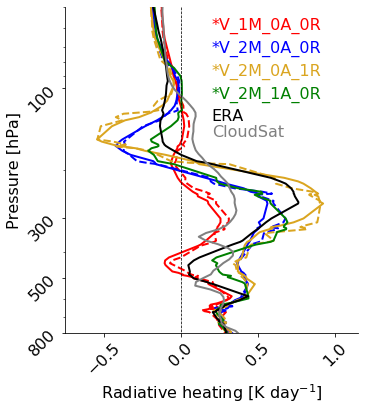

In [25]:
fs = 16
fig = plt.figure(figsize=(5.25,6))
for j, a, rad in zip(np.arange(len(sims)), acronym, H):
    print(j)
    if j < 7:
        plt.plot(rad, pl/100, ls = stil[j], lw = 2, color=farbe[j])
        plt.text(0.5,0.93-0.035*j, a, fontsize=fs, color=farbe[j], transform=plt.gca().transAxes)

plt.plot(H[len(sims)], pl/100, lw = 2, color='k')
#plt.plot((H[j+2,0] + H[j+2,1])/2, pl/100, lw = 2, color='k', linestyle='--')
plt.plot(cs_dtlwcl_AMA+cs_dtswcl_AMA, cs_dtlev, color='gray', linewidth=2)

plt.text(0.5,0.93-0.04*(j+1), 'ERA', fontsize=fs, color='k', transform=plt.gca().transAxes)
#plt.text(0.5,0.93-0.04*(j+1), 'Reanalysis', fontsize=fs, color='k', transform=plt.gca().transAxes)
plt.text(0.5,0.93-0.041*(j+2), 'CloudSat', fontsize=fs, color='gray', transform=plt.gca().transAxes)
#plt.text(0.5,0.93-0.041*(j+2), 'Satellite', fontsize=fs, color='gray', transform=plt.gca().transAxes)

plt.plot([0,0],[50,1000], lw=0.75, linestyle='--', color='k')
plt.gca().set_xlabel(r'Radiative heating [K day$^{-1}$]',fontsize=fs)
plt.gca().set_xlim([-0.75,1.15])
sexy_axes2(plt.gca(),fs,True)

#fig.savefig('./output/2-heating-profiles.pdf',bbox_inches='tight')
fig.savefig('./output/4-heating-profiles-4.pdf',bbox_inches='tight')

## Figure 4: Process figure - qi and qs profiles, ice effective radius and emissivity

In [26]:
sims = ['1mom', 'no2mom', 'novgrid', '2mom', 'radnovgrid', 'rad2mom', 'PDA', 'Atest']
acronym = ['*V_1M_0A_0R', '', '*V_2M_0A_0R', '', '*V_2M_0A_1R', '', '*V_2M_1A_0R', 'A test']

# Load the ice and snow mass mixing ratio profiles.
QI = np.zeros((len(sims), 120))  # second dimension = level number
QS = np.zeros((len(sims), 120))
for j, s in enumerate(sims):
    # Take the average over the first dimension - 24 hours.
    QI[j] = np.nanmean(np.load('./output/QI_' + s + '_PL2.npy'), axis=0)
    QS[j] = np.nanmean(np.load('./output/QS_' + s + '_PL2.npy'), axis=0)

In [27]:
# Effective radius difference between the old and new parameterizations
a0 = 83.8
b0 = 0.216
N = np.linspace(0.1,210,50) # in [cm-3]
iwc = [0.01, 0.1, 0.5, 1]   # in [g m-3]
re_old = np.zeros((len(iwc),len(N)))

nu = 0
mu = 0.333333
ageo = 0.835
bgeo = 0.39
part1 = ageo/2*(gamma((nu + 1)/mu)/gamma((nu + 2)/mu))**bgeo
part2 = gamma((3*bgeo + nu + 1)/mu)/gamma((2*bgeo + nu + 1)/mu)
re_new = np.zeros((len(iwc),len(N)))

for indx, i in enumerate(iwc):
    re_old[indx] = (a0*i**b0)*np.ones(len(N))
    re_new[indx] = part1*part2*((i/10**3)/(N*10**6))**bgeo*10**6

In [28]:
# Extinction per mass crystal difference as reff changes
cldopt = xr.open_dataset('/work/bb1018/b380873/rrtm/rrtm_cldopt.nc')
wavel = cldopt.wavelength
ri = cldopt.re_crystal
# 30 wavelengths, 61 effective radii
kappa = cldopt.extinction_per_mass_crystal

# Which wavelengths to look at?
wavel_sub = np.arange(4,20,3)

# Generate an interpolation function kappa = f(reff)
cubic_interp = []
for i, wl in enumerate(wavel_sub):
    cubic_interp.append(interp1d(ri, kappa.values[i], kind='cubic'))

In [29]:
# Look at the effective radii associated with IWC = 0.01 g m-3

# Where r_new or r_old are less than the tabulated minimum set them to min.
r_new = re_new[0]; r_old = re_old[0]
r_new[np.argwhere((r_new < np.nanmin(ri)))[:,0]] = np.nanmin(ri)
r_old[np.argwhere((r_old < np.nanmin(ri)))[:,0]] = np.nanmin(ri)
    
# Where r_new or r_old are greater than the tabulated maximum set them to max.
r_new[np.argwhere((r_new > np.nanmax(ri)))[:,0]] = np.nanmax(ri)
r_old[np.argwhere((r_old > np.nanmax(ri)))[:,0]] = np.nanmax(ri)

# Interpolate the r_new and r_old values onto the fixed RRTM kappa = f(reff) function.
kappa_new = []
kappa_old = []
for ci in cubic_interp:
    kappa_new.append(ci(r_new))
    kappa_old.append(ci(r_old))

4
7
10
13
16
19


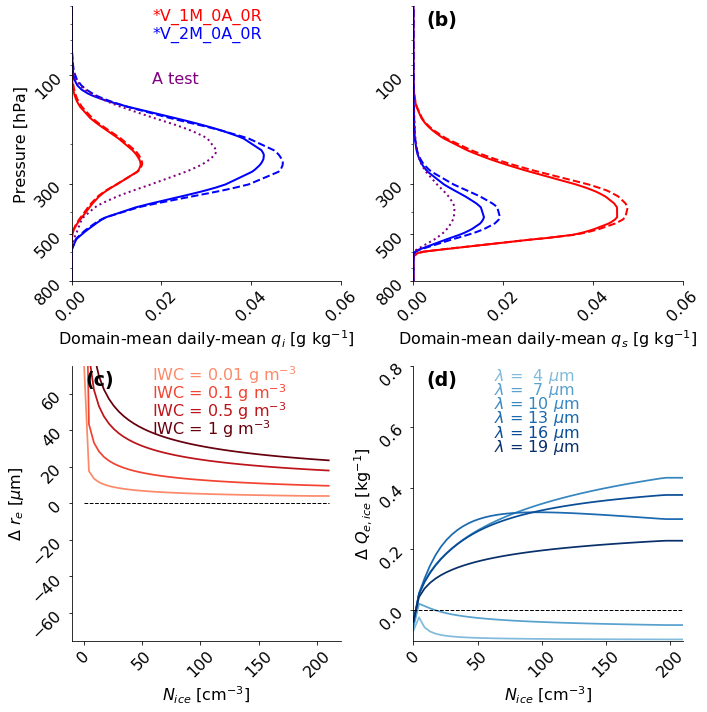

In [35]:
fs = 16
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
for j, ice, snow, a in zip(np.arange(len(sims)), QI, QS, acronym):
    if j < 4 or j == 7:
        ax[0,0].plot(ice*1000, pl/100, linewidth=2, ls = stil[j], color=farbe[j])
        ax[0,1].plot(snow*1000, pl/100, linewidth = 2, ls = stil[j], color=farbe[j])
    #if a != 'A test':
        ax[0,0].text(0.3, 0.95-j*0.033, a, color=farbe[j], fontsize=fs, transform=ax[0,0].transAxes)
    #else:
    #    ax[0,0].text(0.3, 0.95-(j+1)*0.033, a, color=farbe[j], fontsize=fs, transform=ax[0,0].transAxes)
    
ax[0,0].set_xlim([0,0.06])
ax[0,0].set_xlabel(r'Domain-mean daily-mean $q_i$ [g kg$^{-1}$]',fontsize=fs)
#ax[0,0].text(0.05,0.93,'(a)',fontsize=fs+3,weight='bold',transform=ax[0,0].transAxes)
sexy_axes2(ax[0,0], fs, True)

ax[0,1].set_xlim([0,0.06])
ax[0,1].set_xlabel(r'Domain-mean daily-mean $q_s$ [g kg$^{-1}$]',fontsize=fs)
ax[0,1].text(0.05,0.93,'(b)',fontsize=fs+3,weight='bold',transform=ax[0,1].transAxes)
sexy_axes2(ax[0,1], fs, False)

cmapz = cm.Reds(np.linspace(0,1,6))
for i in np.arange(4):
    ax[1,0].plot(N,re_new[i], linewidth=1.75, color=cmapz[i+2])
    #ax[1,0].plot(N,re_old[i],linewidth=1.75,linestyle='--',color=cmapz[i+2])
    ax[1,0].text(0.3,0.95-i*0.066, 'IWC = '+str(iwc[i]) + ' g m$^{-3}$', color=cmapz[i+2],
                transform=ax[1,0].transAxes, fontsize=fs)
ax[1,0].plot([0,210],[0,0],linewidth=1,linestyle='--',color='k')
#ax[1,0].set_xlim([0,210])
ax[1,0].set_ylim([-75,75])
ax[1,0].set_xlabel(r'$N_{ice}$ [cm$^{-3}$]',fontsize=fs)
ax[1,0].set_ylabel('$\Delta$ $r_e$ [$\mu$m]',fontsize=fs)
ax[1,0].text(0.05,0.93,'(c)',fontsize=fs+3,weight='bold',transform=ax[1,0].transAxes)
sexy_axes(ax[1,0],fs)

cmapz = cm.Blues(np.linspace(0,1,len(wavel_sub)+4))
for i, wl in enumerate(wavel_sub):
    print(wl)
    ax[1,1].plot(N, kappa_new[i]-kappa_old[i], linewidth=1.75, color=cmapz[i+4])
    #ax[1,1].plot(N, kappa_old[i], linestyle='--', linewidth=1.75, color=cmapz[i+4])
    ax[1,1].text(0.3,0.95-i*0.052, r'$\lambda$ =' + '{0:3.0f}'.format(wl)+r' $\mu$m', color=cmapz[i+4],
                transform=ax[1,1].transAxes, fontsize=fs)
    
ax[1,1].plot([0,210],[0,0],linewidth=1,linestyle='--',color='k')
ax[1,1].set_xlim([0,210])
ax[1,1].set_ylim([-0.1,0.8])
ax[1,1].set_xlabel(r'$N_{ice}$ [cm$^{-3}$]',fontsize=fs)
ax[1,1].set_ylabel(r'$\Delta$ $Q_{e, ice}$ [kg$^{-1}$]',fontsize=fs)
ax[1,1].text(0.05,0.93,'(d)',fontsize=fs+3,weight='bold',transform=ax[1,1].transAxes)
sexy_axes(ax[1,1],fs)

fig.tight_layout()
fig.savefig('./output/4-qi-qs-reff-emiss-1.pdf',bbox_inches='tight')